### **Dataset and Problem Description**

The dataset used in this project is the **MBA Admission Dataset, Class of 2025**, which is a classification problem. The dataset contains several instances with 9 features, and the target variable is **admission status** (Admit, Waitlist, or Deny). The dataset is relatively balanced but may contain bias due to factors such as gender, race, and academic background, which can affect the fairness of the admissions process.

### **Features**
This dataset includes various attributes of the applicants, such as:

- **application_id**: Unique identifier for each application
- **gender**: Applicant's gender (Male, Female)
- **international**: Whether the applicant is an international student (TRUE/FALSE)
- **gpa**: Grade Point Average (on a 4.0 scale)
- **major**: Undergraduate major (Business, STEM, Humanities)
- **race**: Racial background of the applicant (e.g., White, Black, Asian, Hispanic, Other / null: international student)
- **gmat**: GMAT score (out of 800)
- **work_exp**: Number of years of work experience
- **work_industry**: Industry of previous work experience (e.g., Consulting, Finance, Technology, etc.)
- **admission**: Admission status (Admit, Waitlist, Deny)

### **Why this dataset?**

The **MBA Admission Dataset** and the **Rotterdam system** both share concerns regarding **fairness** and **explainability**, but in different contexts. While the Rotterdam system is punitive, as it denies essential benefits, the MBA admission process is not punitive, though it still has a significant impact on candidates' future professional opportunities. Both systems, however, can be affected by biases such as **gender**, **ethnicity**, and other demographic factors, which may influence the decision-making process in unjust ways.

Just as the Rotterdam system faced criticism for lack of fairness and transparency in its decisions, the MBA admissions process also raises similar concerns. Factors like **gender**, **race**, **academic performance**, and **work experience** can inadvertently introduce bias, potentially leading to unfair outcomes for certain groups. Therefore, **explainability** is crucial in both cases. For the MBA admission process, it is essential to ensure that the decisions are transparent and that the criteria used are well-understood by all stakeholders. This way, we can ensure that admissions are based on merit, not influenced by bias, and that the process is just, transparent, and accountable.

In both cases, addressing fairness and improving explainability will lead to better decision-making, ensuring that individuals are not unfairly excluded or advantaged based on arbitrary or discriminatory factors.

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.inspection import permutation_importance
import shap
shap.initjs()

df = pd.read_csv("MBA.csv")
df.head()

/home/minipoloalex/Documents/IAS-project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


In [3]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [4]:
df.admission = df.admission.fillna('No admit')
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,No admit
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,No admit
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,No admit


In [5]:
df[df.international]["race"].unique()

array([nan], dtype=object)

In [6]:
df.race = df.race.fillna('International')
del(df['international'])

In [7]:
df.isnull().sum().sum()

np.int64(0)

In [8]:
del(df['application_id'])

In [9]:
X_display = df.drop('admission', axis=1)
y_display = df['admission']

In [10]:
admission_mapping = {'Admit': 1, 'Waitlist': 0, 'No admit': 0}
df['admission'] = df.admission.map(admission_mapping)

In [11]:
df.groupby("race")["admission"].mean()

race
Asian            0.165650
Black            0.087336
Hispanic         0.104027
International    0.150923
Other            0.194093
White            0.167582
Name: admission, dtype: float64

In [12]:
df.gender = (df.gender == 'Female').astype(int)

for col in df.select_dtypes(include=['object']).columns: # major race and work_industry
    df[col] = LabelEncoder().fit_transform(df[col])


In [13]:
df.head()

,gender,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,3.30,0,0,620.0,3.0,3,1
1,0,3.28,1,1,680.0,5.0,6,0
2,1,3.30,0,3,710.0,5.0,13,1
3,0,3.47,2,1,690.0,6.0,13,0
4,0,3.35,2,2,590.0,5.0,1,0


In [14]:
df.corr()

,gender,gpa,major,race,gmat,work_exp,work_industry,admission
gender,1.000000,-0.022210,-0.025773,-0.002748,-0.022815,0.007427,-0.001822,0.117084
gpa,-0.022210,1.000000,-0.006697,-0.013919,0.577539,0.000346,-0.009687,0.283404
major,-0.025773,-0.006697,1.000000,-0.016681,0.003594,0.006741,0.014921,-0.007323
race,-0.002748,-0.013919,-0.016681,1.000000,-0.018811,0.011747,-0.009973,0.035476
gmat,-0.022815,0.577539,0.003594,-0.018811,1.000000,-0.000999,-0.001258,0.348319
work_exp,0.007427,0.000346,0.006741,0.011747,-0.000999,1.000000,-0.009811,0.011868
work_industry,-0.001822,-0.009687,0.014921,-0.009973,-0.001258,-0.009811,1.000000,-0.000428
admission,0.117084,0.283404,-0.007323,0.035476,0.348319,0.011868,-0.000428,1.000000


In [15]:
X = df.drop('admission', axis=1)
y = df['admission']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train);

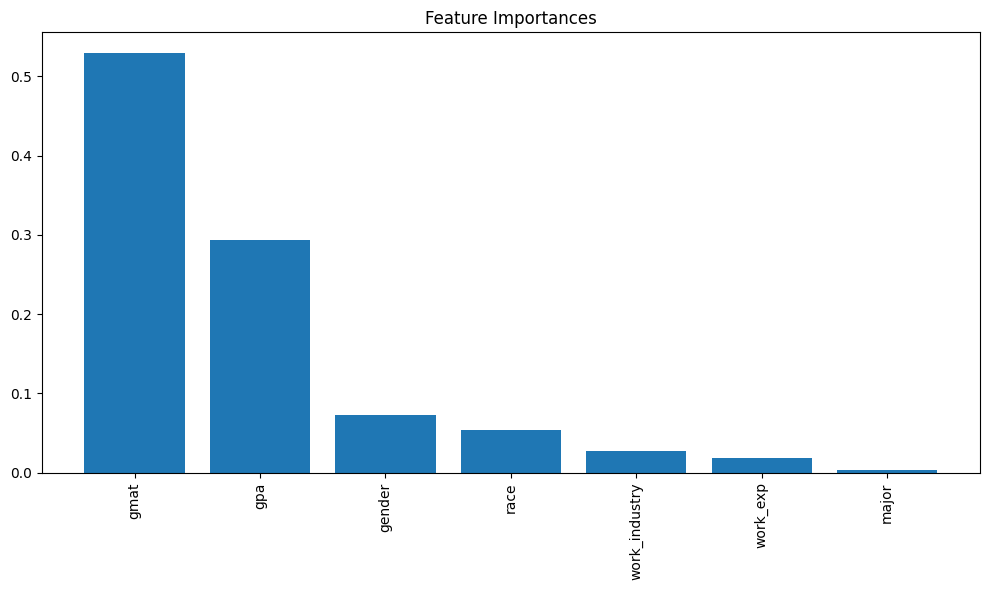

In [18]:
importances = gbc.feature_importances_

# Plot feature importances
feature_importance = sorted(zip(importances, X_train.columns), reverse=True)

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), [imp for imp, _ in feature_importance])
plt.xticks(range(len(importances)), [name for _, name in feature_importance], rotation=90)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In [19]:

# # Create partial dependence plot
# fig, ax = plt.subplots(figsize=(10, 6))
# PartialDependenceDisplay.from_estimator(gbc, X, features=['feature_name'])
# # plt.show()


In [20]:
r = permutation_importance(gbc, X_test, y_test, n_repeats=30, random_state=0)

In [21]:
explainer = shap.TreeExplainer(gbc)
shap_values = explainer.shap_values(X)

In [22]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_display.iloc[0, :])

In [23]:
shap.force_plot(explainer.expected_value, shap_values[:1000, :], X_display.iloc[:1000, :])

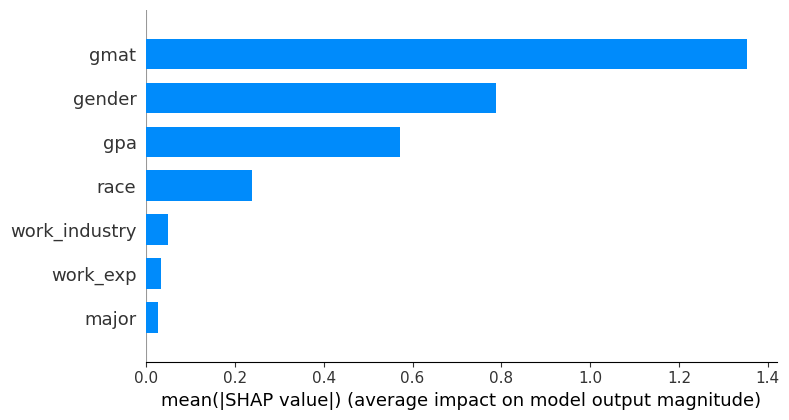

In [24]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

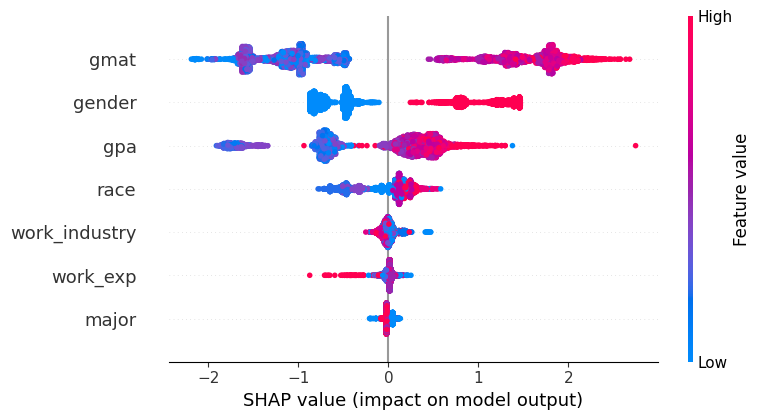

In [25]:
shap.summary_plot(shap_values, X)

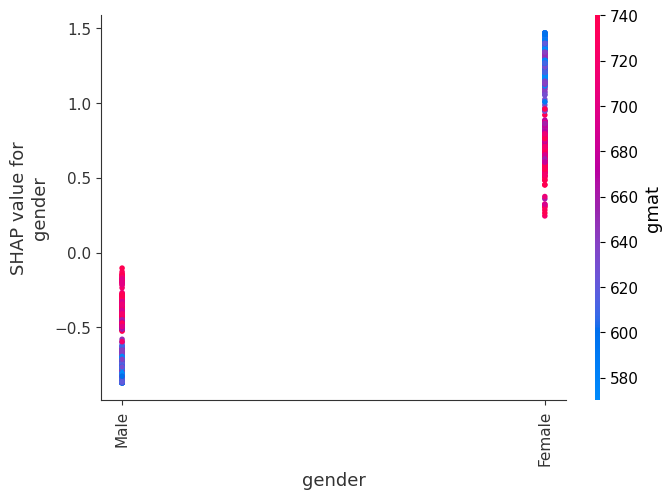

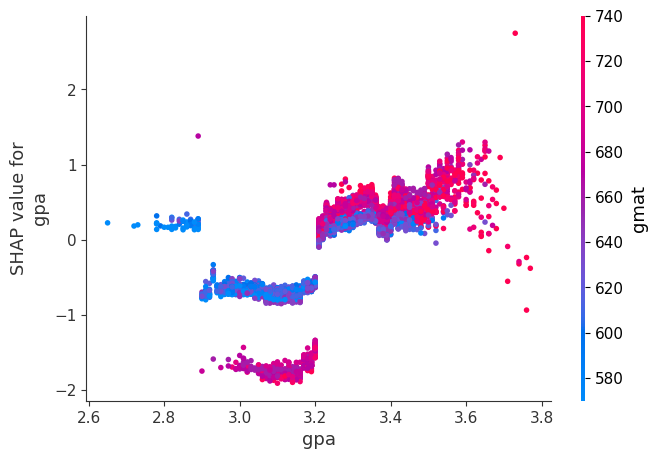

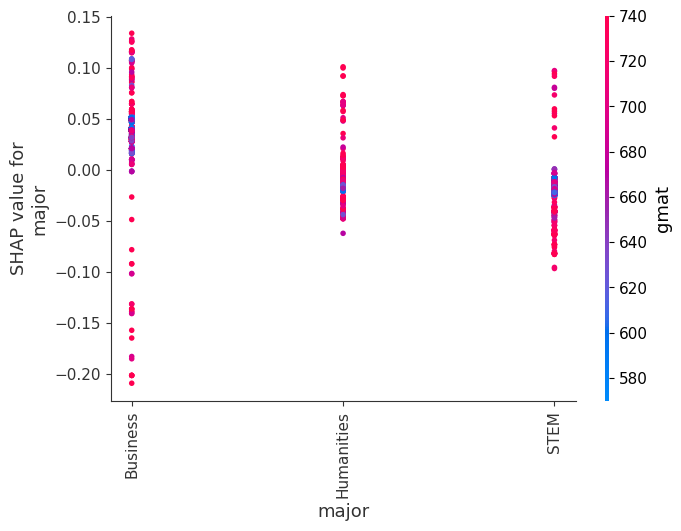

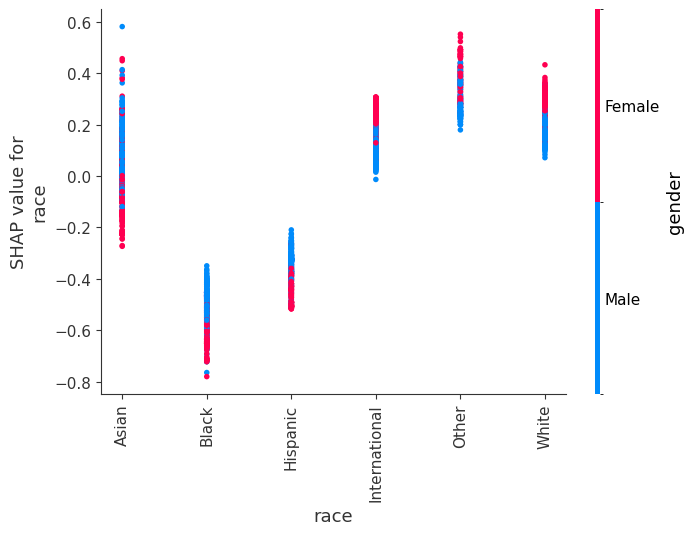

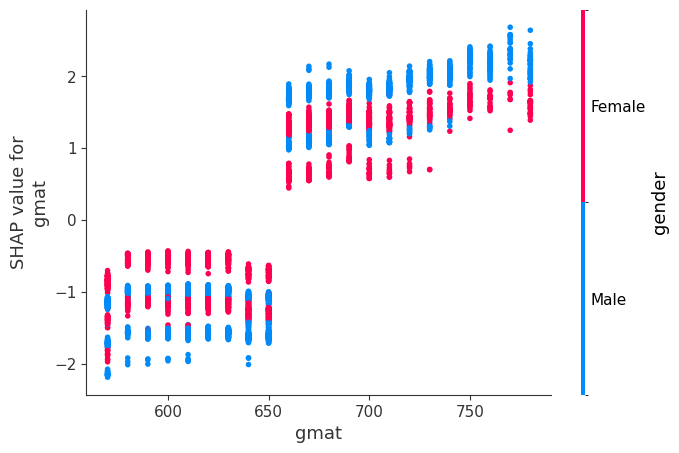

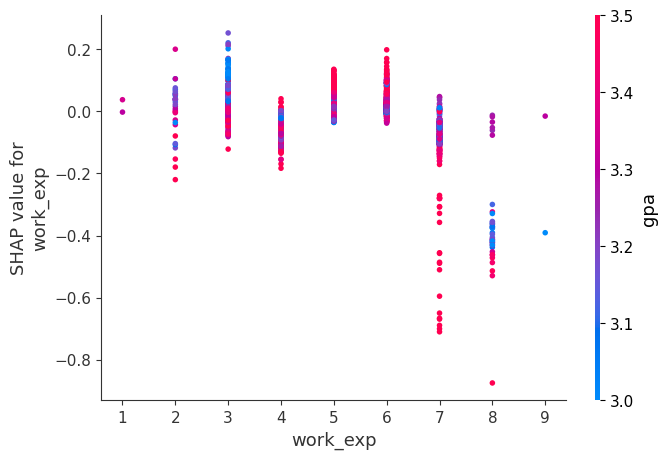

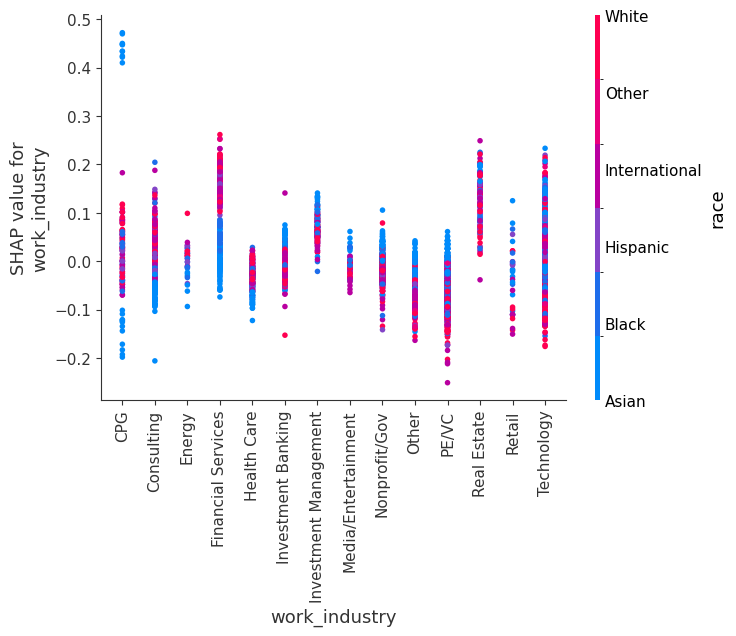

In [26]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)